# Rain Prediction using LR, Tree, XGBoost, NN, CNN, KNN, LSTM, and GRU  
### **By:** Mridul Jain, Lynne Wang, Deepak Kumar Srivastava, Naresh Kumar Chinnathambi Kailasam  
**Course:** MIDS Spring 2025, W207 Final Project  

---

### **Motivation**

Predicting rainfall accurately is crucial for a variety of fields, including agriculture, infrastructure, and disaster preparedness. In this project, we aim to improve rainfall prediction using diverse machine learning approaches, from classical algorithms to deep learning architectures.

Our project used a weather dataset from Kaggle and applied rigorous preprocessing, feature engineering, and model tuning. The best-performing model (an ensemble of top models) achieved a leaderboard-equivalent test score of **0.90376**, ranking **21st out of 4,382** participants.

### **Data**

**Source:** [Kaggle Playground Series - Season 5, Episode 3](https://www.kaggle.com/competitions/playground-series-s5e3)  
**Format:** Tabular weather data  
**Target:** Binary classification (0: No Rain, 1: Rain)  
**Samples:** 2,190 training rows, several thousand in the test set  

**Key Features:**  
- Temperature (max, min, avg)  
- Humidity, dewpoint  
- Wind speed/direction  
- Cloud cover, sunshine hours  
- Atmospheric pressure  

**Preprocessing Techniques:**
- Synthetic features: date, year, month
- Cyclical encoding for `day` and `wind direction`
- Correlation heatmap and EDA (rainy days by month/year)
- Standardization of features
- Train/validation time-based split (80/20)

**Feature Engineering:**
- Added sinusoidal encodings (`day_sin`, `wind_sin`, `year`)
- Constructed lag features (e.g., previous day pressure/humidity)
- Created sequences for CNN/LSTM models

### **Modeling**

We compared 11 models:

**Classical Models:**
- Logistic Regression  
- K-Nearest Neighbors (KNN)  
- Decision Tree  
- Random Forest  
- XGBoost  

**Neural Approaches:**
- Fully Connected Neural Network (MLP)  

**Deep Learning with Sequences:**
- 1D CNN  
- 2D CNN  
- LSTM  
- GRU  

**Final Ensemble:**  
- Combined outputs of the top-performing models using a weighted average of probabilities.

### **Experiments**

#### **Validation Accuracy vs. Test Score:**

| Model            | Validation Accuracy | Test Score |
|------------------|---------------------|------------|
| Logistic Regression | 0.8837              | 0.8961     |
| KNN                 | 0.8744              | 0.8716     |
| Decision Tree       | 0.8676              | 0.8556     |
| Random Forest       | 0.8744              | 0.8958     |
| XGBoost             | 0.8721              | 0.8998     |
| Neural Network      | 0.8790              | 0.9014     |
| 1D CNN              | 0.8833              | 0.8916     |
| 2D CNN              | 0.8787              | 0.8879     |
| LSTM                | 0.8767              | 0.8959     |
| GRU                 | 0.8699              | 0.8972     |
| **Ensemble**        | —                   | **0.9038** |

#### **Hyperparameter Exploration Highlights:**
- **XGBoost**:
  - `n_estimators = 300`, `max_depth = 6`, `learning_rate = 0.05–0.1`
  - Regularization (`alpha = 1`) and `scale_pos_weight = 3` to handle class imbalance

- **Neural Network (MLP)**:
  - 3 dense layers with ReLU
  - SGD optimizer with early stopping
  - Final val accuracy: **0.8721**, ROC AUC: **0.88**

- **1D CNN**:
  - 8-day sliding window  
  - Conv1D → MaxPooling → Dropout → Dense  
  - Final val accuracy: **0.8810**

- **2D CNN**:
  - Reshaped input into (days, features) image  
  - Conv2D with `4x4` kernel → pooling → dropout  
  - Val accuracy: **0.8696**

- **LSTM & GRU**:
  - Bidirectional layers with dropout  
  - Similar val accuracy to CNNs (~0.87–0.88)

- **Ensemble Model**:
  - Weighted combination of predictions from different combinations
  - Best test score: **0.90376**


### **Conclusions**

- Neural and ensemble models outperform simpler models on this task.
- Feature engineering, particularly time-based encoding and wind direction transformation, improved all models.
- CNNs and recurrent architectures handle sequential dependencies in weather well.
- Ensemble modeling achieved near-top leaderboard performance on Kaggle (rank **21/4382**).

**Outcome**:
- The top leaderboard score was 0.90654.
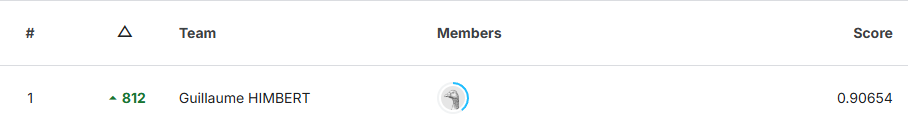
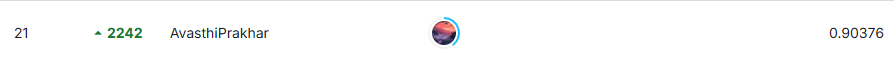
- Our ensemble achieved a score of 0.90376, which would have ranked 21st out of 4,382 participants.
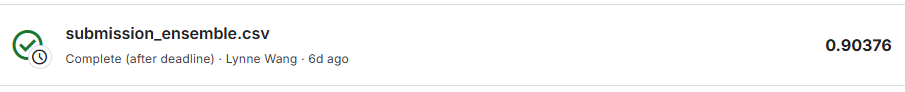

### **Code Submission**

GitHub Repository: [https://github.com/lwang9/mids-w207-final_project_team2](https://github.com/lwang9/mids-w207-final_project_team2)

### **Contributions**
- Mridul Jain: EDA, data pre-processing, lr, tree, xgboost, LSTM, gru models building and tuning, slides preparation.
- Lynne Wang: EDA, data pre-processing, lr, tree, xgboost, nn, cnn, knn models building and tuning, slides preparation.
- Deepak Kumar Srivastava: EDA, data pre-processing, lr, tree, xgboost, nn, LSTM models building and tuning, slides preparation.
- Naresh Kumar Chinnathambi Kailasam: EDA, data pre-processing, lr, tree, xgboost, nn, LSTM models building and tuning, slides preparation.



In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from xgboost import XGBClassifier
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_auc_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

import glob

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA & Data Preprocessing

In [2]:
# Load the training data
PATH = '/content/drive/My Drive/Colab Notebooks/207 Final/'
train_df = pd.read_csv(PATH+'train.csv')
test_df = pd.read_csv(PATH+'test.csv')
test_df2 = pd.read_csv(PATH+'test_extra7.csv')
# Show basic info and first few rows
train_info = train_df.info()
train_head = train_df.head()

train_info, train_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


(None,
    id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
 0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
 1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
 2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
 3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
 4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   
 
    cloud  sunshine  winddirection  windspeed  rainfall  
 0   88.0       1.1           60.0       17.2         1  
 1   91.0       0.0           50.0       21.9         1  
 2   47.0       8.3           70.0       18.1         1  
 3   95.0       0.0           60.0       35.6         1  
 4   45.0       3.6           40.0       24.8         0  )

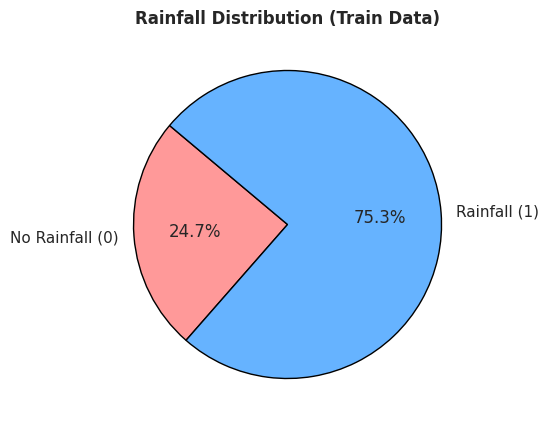

In [3]:
# Check if the 'rainfall' column exists in the train dataset
if 'rainfall' not in train_df.columns:
    print("The 'rainfall' column is missing in the train dataset.")
else:
    # Count occurrences of 0 and 1 for the train set
    train_rainfall_counts = train_df['rainfall'].value_counts()

    # Labels and sizes for the pie chart
    labels = ['No Rainfall (0)', 'Rainfall (1)']
    train_sizes = [train_rainfall_counts.get(0, 0), train_rainfall_counts.get(1, 0)]

    colors = ['#ff9999', '#66b3ff']

    # Plotting the pie chart for the train set
    plt.figure(figsize=(5, 5))
    plt.pie(train_sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
    plt.title('Rainfall Distribution (Train Data)',fontweight='bold')

    plt.show()

In [4]:
## Baseline model
# Drop unnecessary columns
X = train_df.drop(columns=['id', 'rainfall'])  # Drop 'id' if it's just a row identifier
y = train_df['rainfall']

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8561643835616438
Confusion Matrix:
 [[ 74  45]
 [ 18 301]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.62      0.70       119
           1       0.87      0.94      0.91       319

    accuracy                           0.86       438
   macro avg       0.84      0.78      0.80       438
weighted avg       0.85      0.86      0.85       438



In [5]:
# Predict regression values (no rounding)
X_test = test_df.drop(columns=['id'])
y_test_pred = log_reg.predict_proba(X_test)[:, 1]

# Prepare submission file with continuous predictions
submission = pd.DataFrame({
    'id': test_df['id'],
    'rainfall': y_test_pred
})

submission.to_csv(PATH + 'submission_base.csv', index=False)

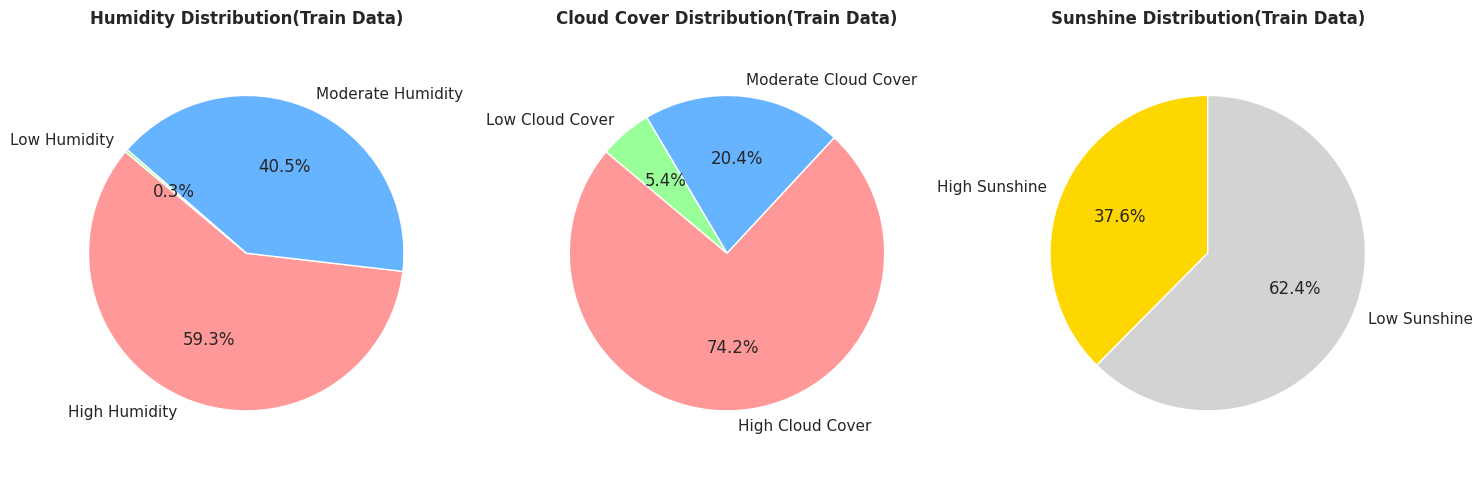

In [6]:
# Assuming Orig_train_df is your DataFrame
# Replace this with loading your data if not already in the variable
# Orig_train_df = pd.read_csv('your_file.csv')

# Classify humidity into categories
high_humidity = sum(train_df['humidity'] >= 80)
moderate_humidity = sum((train_df['humidity'] >= 50) & (train_df['humidity'] < 80))
low_humidity = sum(train_df['humidity'] < 50)

# Data for the humidity pie chart
humidity_labels = ['High Humidity', 'Moderate Humidity', 'Low Humidity']
humidity_sizes = [high_humidity, moderate_humidity, low_humidity]
humidity_colors = ['#ff9999','#66b3ff','#99ff99']

# Classify cloud cover into categories
high_cloud_cover = sum(train_df['cloud'] >= 70)
moderate_cloud_cover = sum((train_df['cloud'] >= 40) & (train_df['cloud'] < 70))
low_cloud_cover = sum(train_df['cloud'] < 40)

# Data for the cloud cover pie chart
cloud_labels = ['High Cloud Cover', 'Moderate Cloud Cover', 'Low Cloud Cover']
cloud_sizes = [high_cloud_cover, moderate_cloud_cover, low_cloud_cover]
cloud_colors = ['#ff9999','#66b3ff','#99ff99']

# Classify sunshine into categories
sunshine_values = train_df['sunshine']
sunshine_labels = ['High Sunshine', 'Low Sunshine']
sunshine_sizes = [sum(sunshine_values > 4), sum(sunshine_values <= 4)]
sunshine_colors = ['gold', 'lightgrey']

# Create subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting the humidity pie chart
axs[0].pie(humidity_sizes, labels=humidity_labels, autopct='%1.1f%%', startangle=140, colors=humidity_colors)
axs[0].set_title('Humidity Distribution(Train Data)',fontweight='bold')
axs[0].axis('equal')  # Equal aspect ratio ensures the pie chart is a circle.

# Plotting the cloud cover pie chart
axs[1].pie(cloud_sizes, labels=cloud_labels, autopct='%1.1f%%', startangle=140, colors=cloud_colors)
axs[1].set_title('Cloud Cover Distribution(Train Data)',fontweight='bold')
axs[1].axis('equal')

# Plotting the sunshine pie chart
axs[2].pie(sunshine_sizes, labels=sunshine_labels, autopct='%1.1f%%', startangle=90, colors=sunshine_colors)
axs[2].set_title('Sunshine Distribution(Train Data)',fontweight='bold')
axs[2].axis('equal')

# Show the plots
plt.tight_layout()
plt.show()


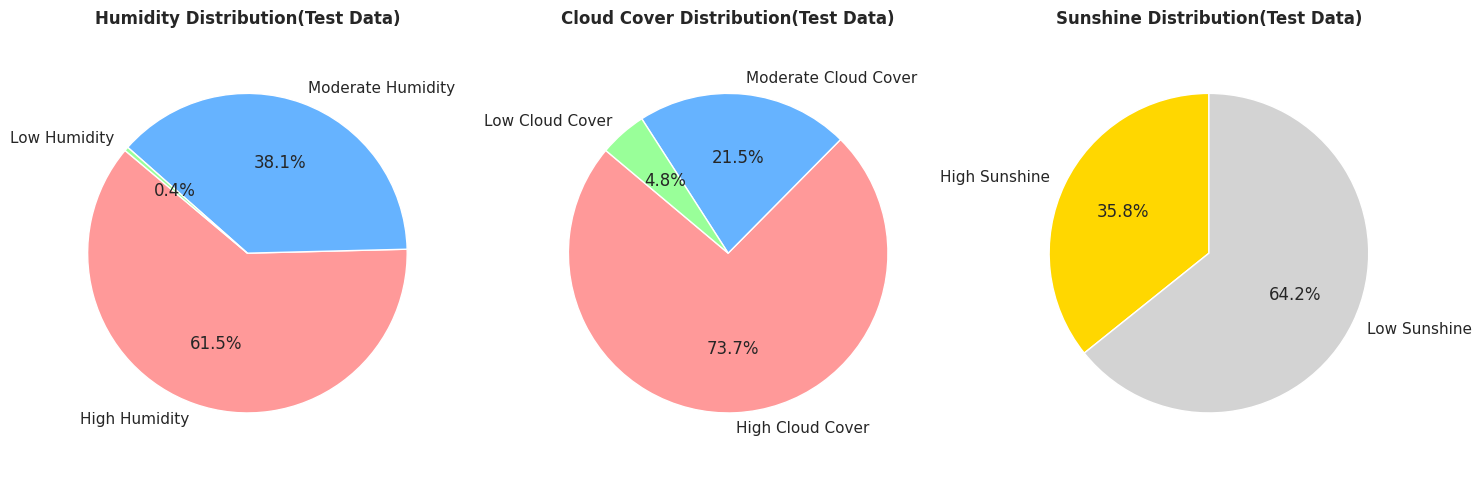

In [7]:
# Assuming Orig_test_df is your DataFrame
# Replace this with loading your data if not already in the variable
# Orig_test_df = pd.read_csv('your_test_file.csv')

# Classify humidity into categories
high_humidity = sum(test_df['humidity'] >= 80)
moderate_humidity = sum((test_df['humidity'] >= 50) & (test_df['humidity'] < 80))
low_humidity = sum(test_df['humidity'] < 50)

# Data for the humidity pie chart
humidity_labels = ['High Humidity', 'Moderate Humidity', 'Low Humidity']
humidity_sizes = [high_humidity, moderate_humidity, low_humidity]
humidity_colors = ['#ff9999','#66b3ff','#99ff99']

# Classify cloud cover into categories
high_cloud_cover = sum(test_df['cloud'] >= 70)
moderate_cloud_cover = sum((test_df['cloud'] >= 40) & (test_df['cloud'] < 70))
low_cloud_cover = sum(test_df['cloud'] < 40)

# Data for the cloud cover pie chart
cloud_labels = ['High Cloud Cover', 'Moderate Cloud Cover', 'Low Cloud Cover']
cloud_sizes = [high_cloud_cover, moderate_cloud_cover, low_cloud_cover]
cloud_colors = ['#ff9999','#66b3ff','#99ff99']

# Classify sunshine into categories
sunshine_values = test_df['sunshine']
sunshine_labels = ['High Sunshine', 'Low Sunshine']
sunshine_sizes = [sum(sunshine_values > 4), sum(sunshine_values <= 4)]
sunshine_colors = ['gold', 'lightgrey']

# Create subplots (3 rows, 1 column)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting the humidity pie chart
axs[0].pie(humidity_sizes, labels=humidity_labels, autopct='%1.1f%%', startangle=140, colors=humidity_colors)
axs[0].set_title('Humidity Distribution(Test Data)',fontweight='bold')
axs[0].axis('equal')  # Equal aspect ratio ensures the pie chart is a circle.

# Plotting the cloud cover pie chart
axs[1].pie(cloud_sizes, labels=cloud_labels, autopct='%1.1f%%', startangle=140, colors=cloud_colors)
axs[1].set_title('Cloud Cover Distribution(Test Data)',fontweight='bold')
axs[1].axis('equal')

# Plotting the sunshine pie chart
axs[2].pie(sunshine_sizes, labels=sunshine_labels, autopct='%1.1f%%', startangle=90, colors=sunshine_colors)
axs[2].set_title('Sunshine Distribution(Test Data)',fontweight='bold')
axs[2].axis('equal')

# Show the plots
plt.tight_layout()
plt.show()


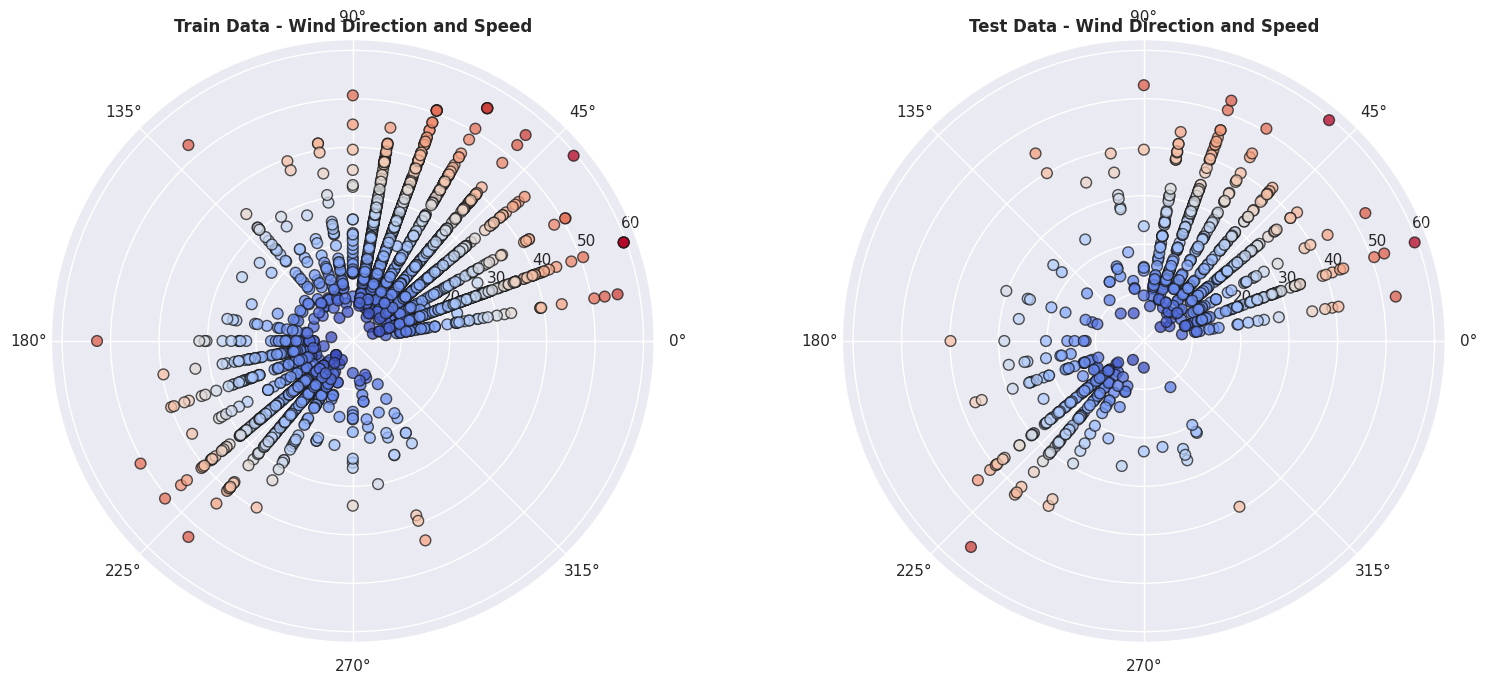

In [8]:
# Example data for the train dataset
wind_direction_train = train_df['winddirection']  # Degrees (0-360)
wind_speed_train = train_df['windspeed']  # Wind speed in m/s or km/h

# Example data for the test dataset
wind_direction_test = test_df['winddirection']  # Degrees (0-360)
wind_speed_test = test_df['windspeed']  # Wind speed in m/s or km/h

# Create side-by-side polar plots for train and test data
fig, axs = plt.subplots(1, 2, figsize=(16, 7), subplot_kw=dict(polar=True))

# Polar plot for train data
theta_train = np.radians(wind_direction_train)
r_train = wind_speed_train
axs[0].scatter(theta_train, r_train, c=r_train, cmap='coolwarm', alpha=0.75, edgecolors="k", s=60)
axs[0].set_title('Train Data - Wind Direction and Speed',fontweight='bold')

# Polar plot for test data
theta_test = np.radians(wind_direction_test)
r_test = wind_speed_test
axs[1].scatter(theta_test, r_test, c=r_test, cmap='coolwarm', alpha=0.75, edgecolors="k", s=60)
axs[1].set_title('Test Data - Wind Direction and Speed',fontweight='bold')

plt.tight_layout()
plt.show()



<Figure size 1200x700 with 0 Axes>

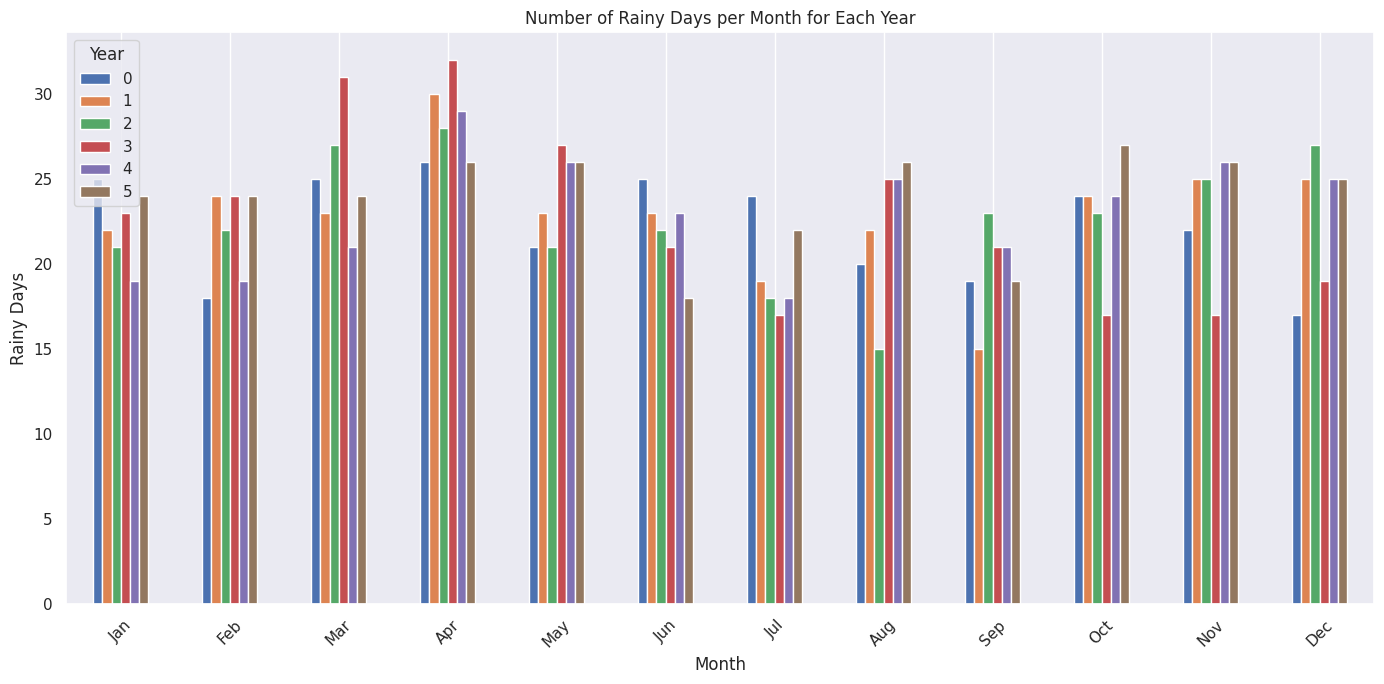

In [9]:
# Create a synthetic date using day of year assuming year 2000 as base (for day to date conversion)
train_df['date'] = pd.to_datetime(train_df['day'], format='%j', errors='coerce')

# Add synthetic year for splitting into multiple years (e.g., assume 6 years total if 2190/365 ≈ 6)
num_years = 6
train_df['year'] = (train_df.index // 365)
train_df['month'] = train_df['date'].dt.month

# Group by year and month to count rainy days
rainy_days = train_df[train_df['rainfall'] == 1].groupby(['year', 'month']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 7))
rainy_days.T.plot(kind='bar', figsize=(14, 7))
plt.title('Number of Rainy Days per Month for Each Year')
plt.xlabel('Month')
plt.ylabel('Rainy Days')
plt.xticks(ticks=range(0, 12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend(title='Year')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [10]:
# Transform 'day' feature
day_frac = (train_df['day'] - 1) / 365  # range: 0 to ~1
day_radians = 2 * np.pi * day_frac
train_df['day_sin'] = np.sin(day_radians)

# Transform 'winddirection' feature
wind_radians = 2 * np.pi * train_df['winddirection'] / 360
train_df['wind_sin'] = np.sin(wind_radians)

train_info = train_df.info()
train_head = train_df.head()

train_info, train_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             2190 non-null   int64         
 1   day            2190 non-null   int64         
 2   pressure       2190 non-null   float64       
 3   maxtemp        2190 non-null   float64       
 4   temparature    2190 non-null   float64       
 5   mintemp        2190 non-null   float64       
 6   dewpoint       2190 non-null   float64       
 7   humidity       2190 non-null   float64       
 8   cloud          2190 non-null   float64       
 9   sunshine       2190 non-null   float64       
 10  winddirection  2190 non-null   float64       
 11  windspeed      2190 non-null   float64       
 12  rainfall       2190 non-null   int64         
 13  date           2190 non-null   datetime64[ns]
 14  year           2190 non-null   int64         
 15  month          2190 n

(None,
    id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
 0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
 1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
 2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
 3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
 4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   
 
    cloud  sunshine  winddirection  windspeed  rainfall       date  year  \
 0   88.0       1.1           60.0       17.2         1 1900-01-01     0   
 1   91.0       0.0           50.0       21.9         1 1900-01-02     0   
 2   47.0       8.3           70.0       18.1         1 1900-01-03     0   
 3   95.0       0.0           60.0       35.6         1 1900-01-04     0   
 4   45.0       3.6           40.0       24.8         0 1900-01-05     0   
 
    month   day_sin  wind_sin  
 0      1  0.000000  0.866025  
 1      1  0.

In [11]:
# # Add a previous day's feature

# # Create lag features for the previous 2 days for selected columns
# lag_features = [
#     "pressure", "maxtemp", "temparature", "mintemp", "dewpoint",
#     "humidity", "cloud", "sunshine", "windspeed", "day_sin", "wind_sin"
# ]

# # Generate lag features for day -1 and day -2
# for lag in [1]:
#     for col in lag_features:
#         train_df[f"{col}_prev_{lag}"] = train_df[col].shift(lag)

# # Drop rows with NaNs introduced by shifting
# train_df = train_df.dropna().reset_index(drop=True)

# train_df

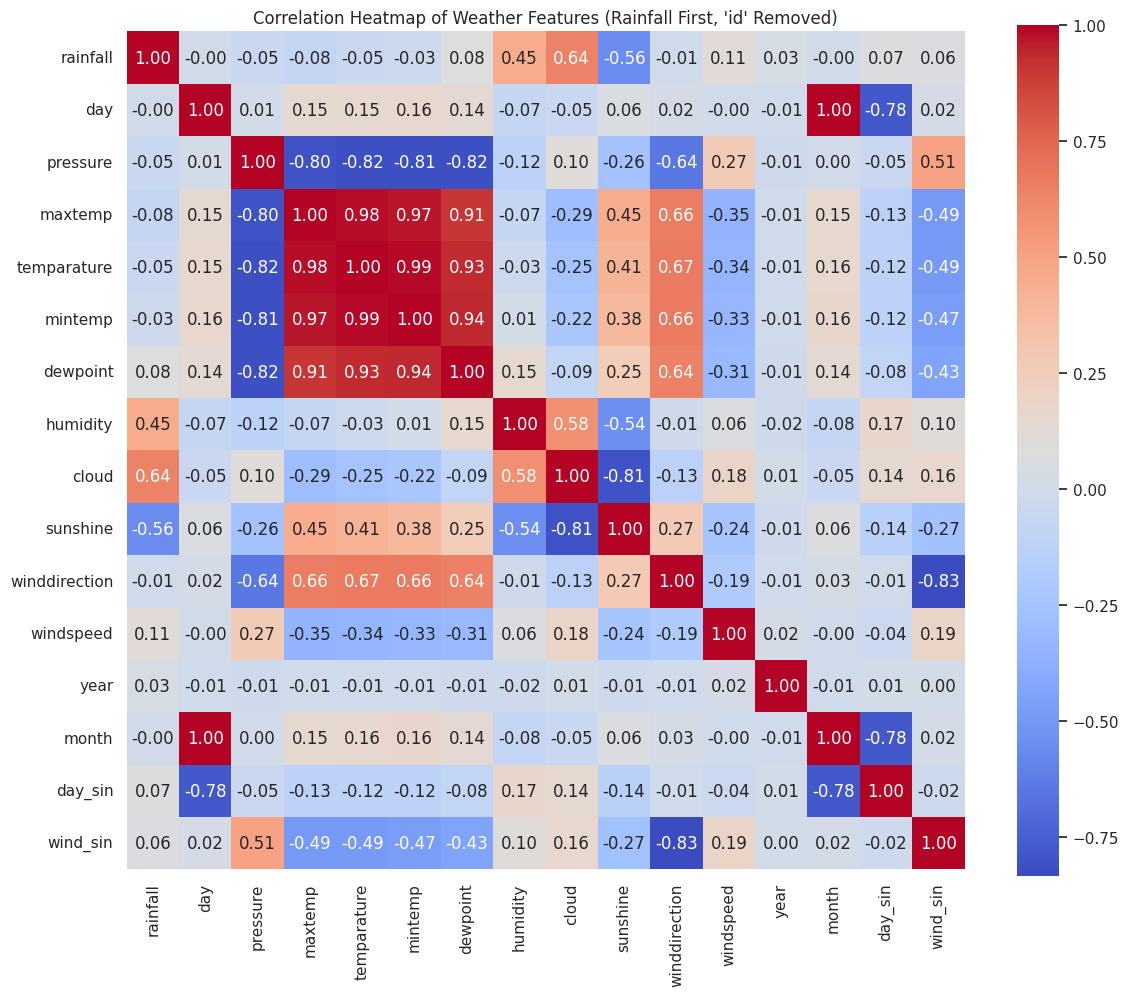

In [12]:
# Calculate correlation matrix without 'id'
correlation_matrix = train_df.drop(columns='id').corr(numeric_only=True)

# Move 'rainfall' to the first row/column
cols = correlation_matrix.columns.tolist()
cols.insert(0, cols.pop(cols.index('rainfall')))
correlation_matrix = correlation_matrix.loc[cols, cols]

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Correlation Heatmap of Weather Features (Rainfall First, 'id' Removed)")
plt.tight_layout()
plt.show()


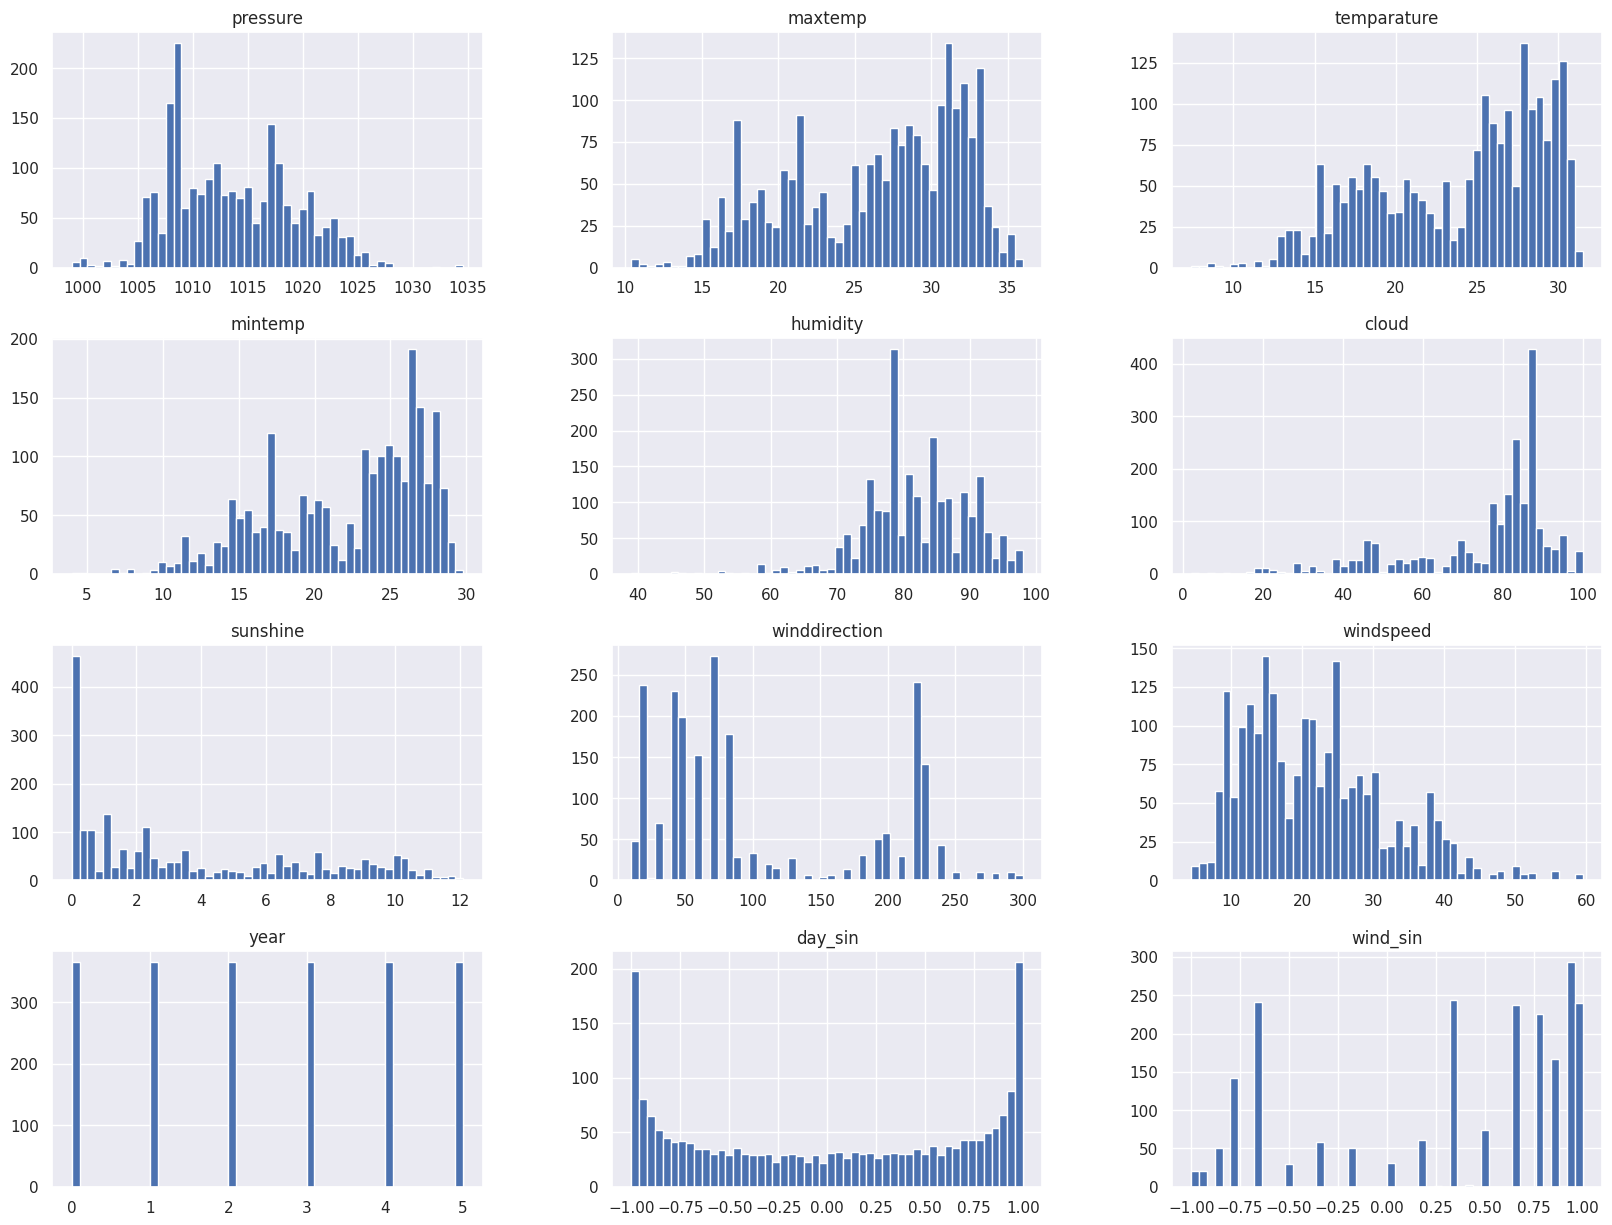

In [13]:
# Drop non-feature columns and isolate target

# List of columns to keep
columns_to_keep = [
    'pressure', 'maxtemp', 'temparature', 'mintemp', 'humidity',
    'cloud', 'sunshine', 'winddirection', 'windspeed',
    'year', 'day_sin', 'wind_sin'
]

# Show the resulting DataFrame columns
train_df.columns.tolist()

X = train_df[columns_to_keep]
y = train_df['rainfall']

X.hist(bins=50, figsize=(20,15))
plt.show()

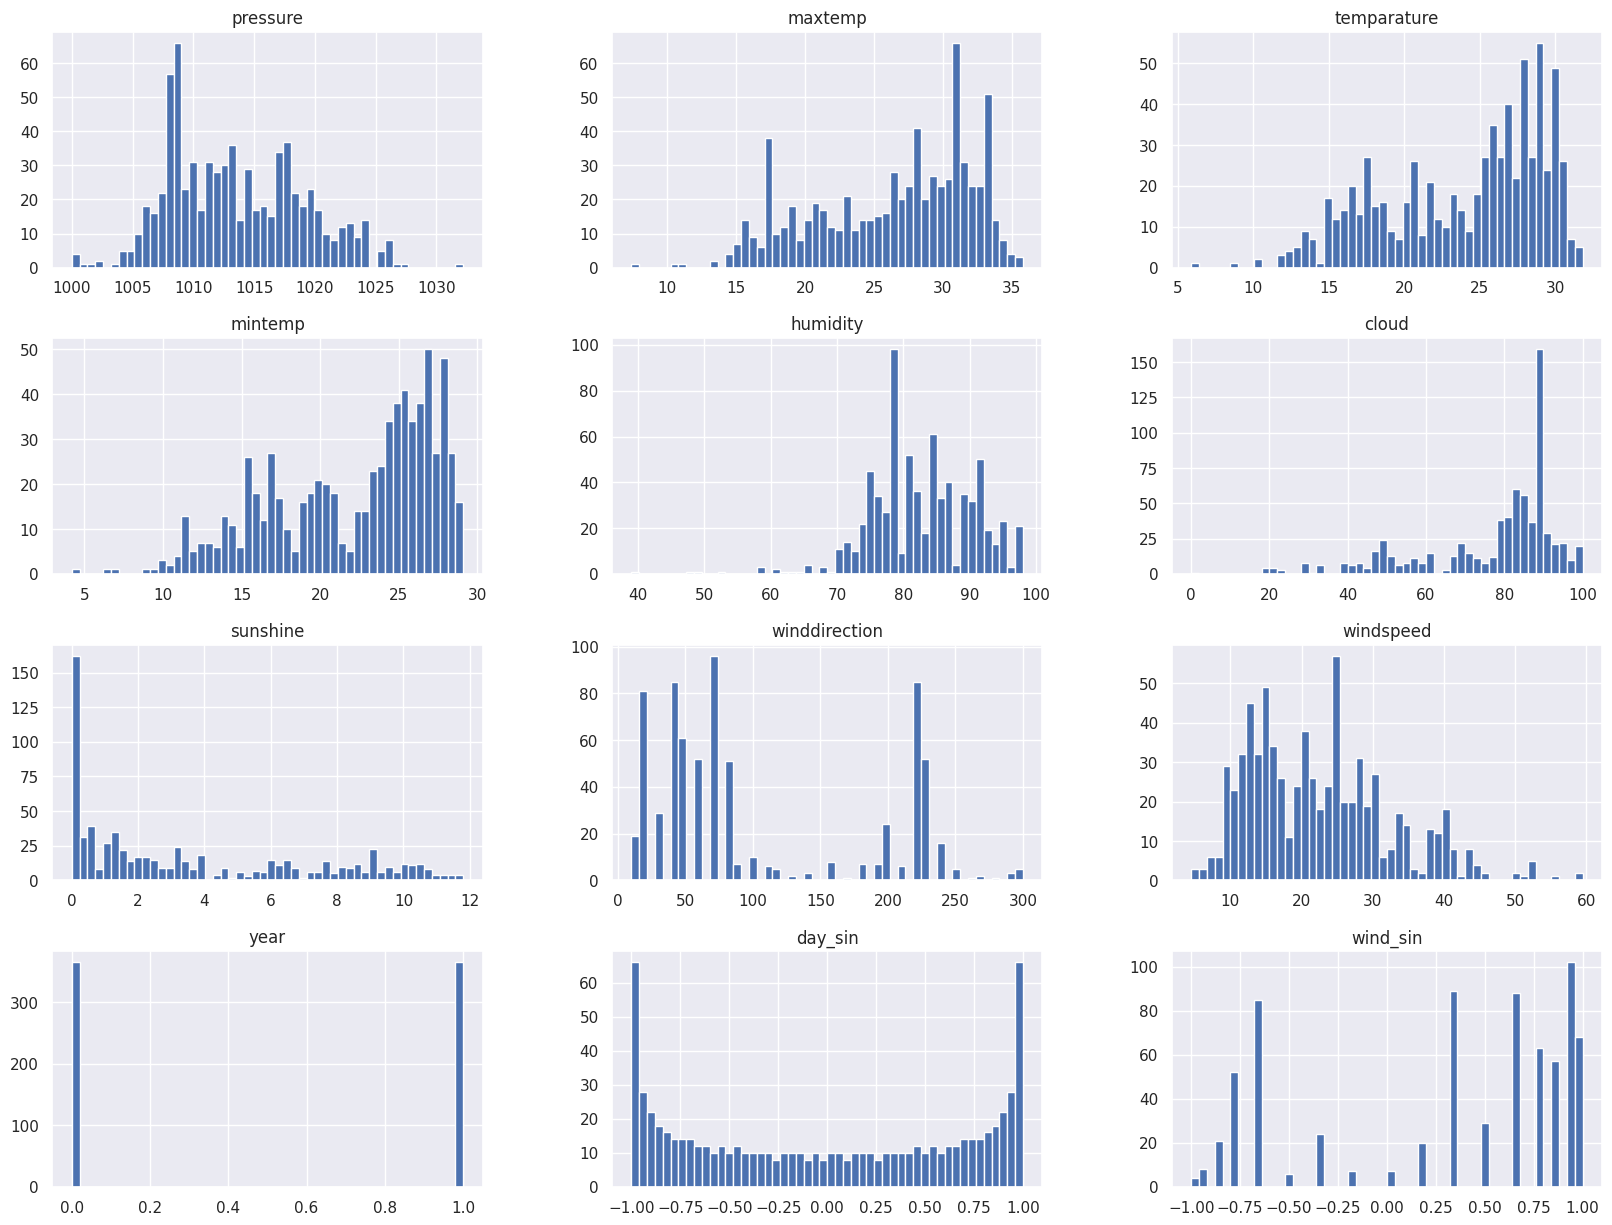

In [14]:
# Create synthetic date from 'day'
test_df['date'] = pd.to_datetime(test_df['day'], format='%j', errors='coerce')

# Simulate year assignment just like train_df (e.g., assume up to 6 years of data)
test_df['year'] = (test_df.index // 365)

# Extract month from synthetic date
test_df['month'] = test_df['date'].dt.month

# Create cyclical features
test_df['day_sin'] = np.sin(2 * np.pi * (test_df['day'] - 1) / 365)
test_df['wind_sin'] = np.sin(2 * np.pi * test_df['winddirection'] / 360)


# Select the same feature columns
X_test = test_df[columns_to_keep]

# Show the resulting DataFrame columns
X_test.columns.tolist()

X_t = X_test[columns_to_keep]

X_t.hist(bins=50, figsize=(20,15))
plt.show()





In [15]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time-based split: use first 80% for training, remaining 20% for validation
split_index = int(len(X_scaled) * 0.8)
X_train, X_val = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_val = y[:split_index], y[split_index:]


## Training Models
### Logistic Regression

In [16]:
# Train logistic regression model
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_train_pred = model_lr.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Logistic Regression Training Accuracy: {train_acc:.4f}")

y_val_pred = model_lr.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Logistic Regression validation Accuracy: {val_acc:.4f}")
#print(classification_report(y_val, y_pred))

train_preds = model_lr.predict_proba(X_train)
print('Training Accuracy : ', metrics.roc_auc_score(y_train, train_preds[:,1]))

val_preds = model_lr.predict_proba(X_val)
print('Validation Accuracy : ', metrics.roc_auc_score(y_val, val_preds[:,1]))
print()

# Evaluate model
y_pred = model_lr.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Logistic Regression Training Accuracy: 0.8670
Logistic Regression validation Accuracy: 0.8653
Training Accuracy :  0.8972769226555654
Validation Accuracy :  0.8837961799447097

Accuracy: 0.865296803652968

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.57      0.64        92
           1       0.89      0.95      0.92       346

    accuracy                           0.87       438
   macro avg       0.81      0.76      0.78       438
weighted avg       0.86      0.87      0.86       438



<Figure size 600x600 with 0 Axes>

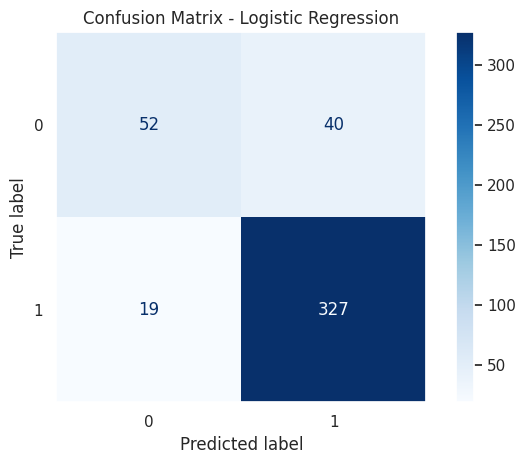

In [17]:
# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lr.classes_)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.grid(False)
plt.show()


In [18]:
# Applying the trained model to test set
# Scale using the same scaler
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled[0])

# Predict probabilities
test_probs = model_lr.predict_proba(X_test_scaled)[:, 1]  # Probability of rainfall (label 1)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'rainfall': test_probs
})

# Save to CSV
submission.to_csv(PATH + "submission_lr.csv", index=False)

[ 1.04311572 -1.56832434 -1.56152458 -1.87231256  1.79044735  1.29162077
 -1.03280391 -0.6859253   0.25214191 -1.46385011 -0.02004369  0.66623427]


### K-Nearest Neighbor (KNN)

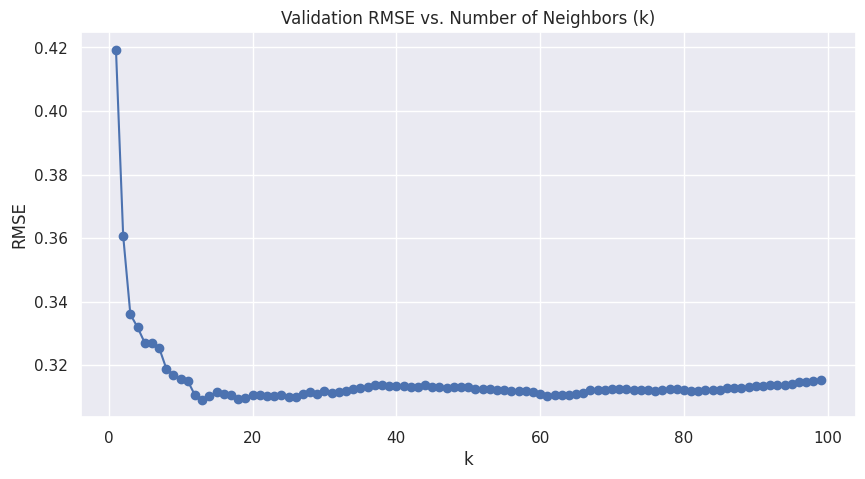

In [19]:
rmse_list = []
for k in range(1, 100):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_list.append(rmse)
    #print(f"k = {k}, RMSE = {rmse:.4f}")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100), rmse_list, marker='o')
plt.title('Validation RMSE vs. Number of Neighbors (k)')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

Best k: 13, Lowest RMSE: 0.3091
Train Accuracy: 0.8716
Validation Accuracy: 0.8744


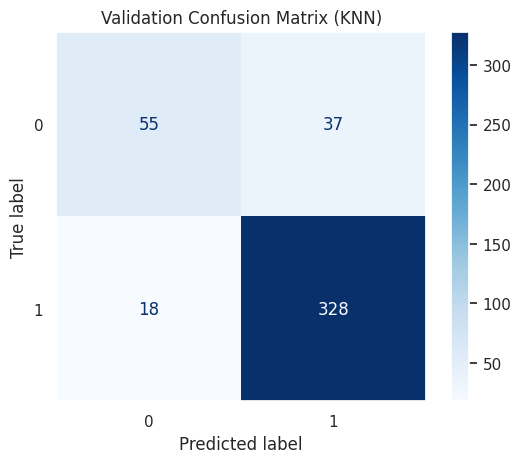

In [20]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_val_flat = X_val.reshape((X_val.shape[0], -1))

best_k = np.argmin(rmse_list) + 1  # +1 because range starts from 1
best_rmse = rmse_list[best_k - 1]
print(f"Best k: {best_k}, Lowest RMSE: {best_rmse:.4f}")
neigh = KNeighborsRegressor(n_neighbors=13)
neigh.fit(X_train_flat, y_train)

# Predict and round for classification
y_train_pred = np.round(neigh.predict(X_train_flat)).astype(int)
y_val_pred = np.round(neigh.predict(X_val_flat)).astype(int)

# Round true labels too (just in case)
y_train_true = np.round(y_train).astype(int)
y_val_true = np.round(y_val).astype(int)

# Compute accuracy
train_accuracy = accuracy_score(y_train_true, y_train_pred)
val_accuracy = accuracy_score(y_val_true, y_val_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate and display confusion matrix for validation set
cm = confusion_matrix(y_val_true, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Validation Confusion Matrix (KNN)")
plt.grid(False)
plt.show()

In [21]:
# Predict regression values (no rounding)
y_test_pred = neigh.predict(X_test_scaled)

# Prepare submission file with continuous predictions
submission = pd.DataFrame({
    'id': test_df['id'],
    'rainfall': y_test_pred
})

submission.to_csv(PATH + 'submission_knn.csv', index=False)

### Decision Tree Model

Validation Accuracy: 0.867579908675799

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.67      0.68        92
           1       0.91      0.92      0.92       346

    accuracy                           0.87       438
   macro avg       0.80      0.80      0.80       438
weighted avg       0.87      0.87      0.87       438



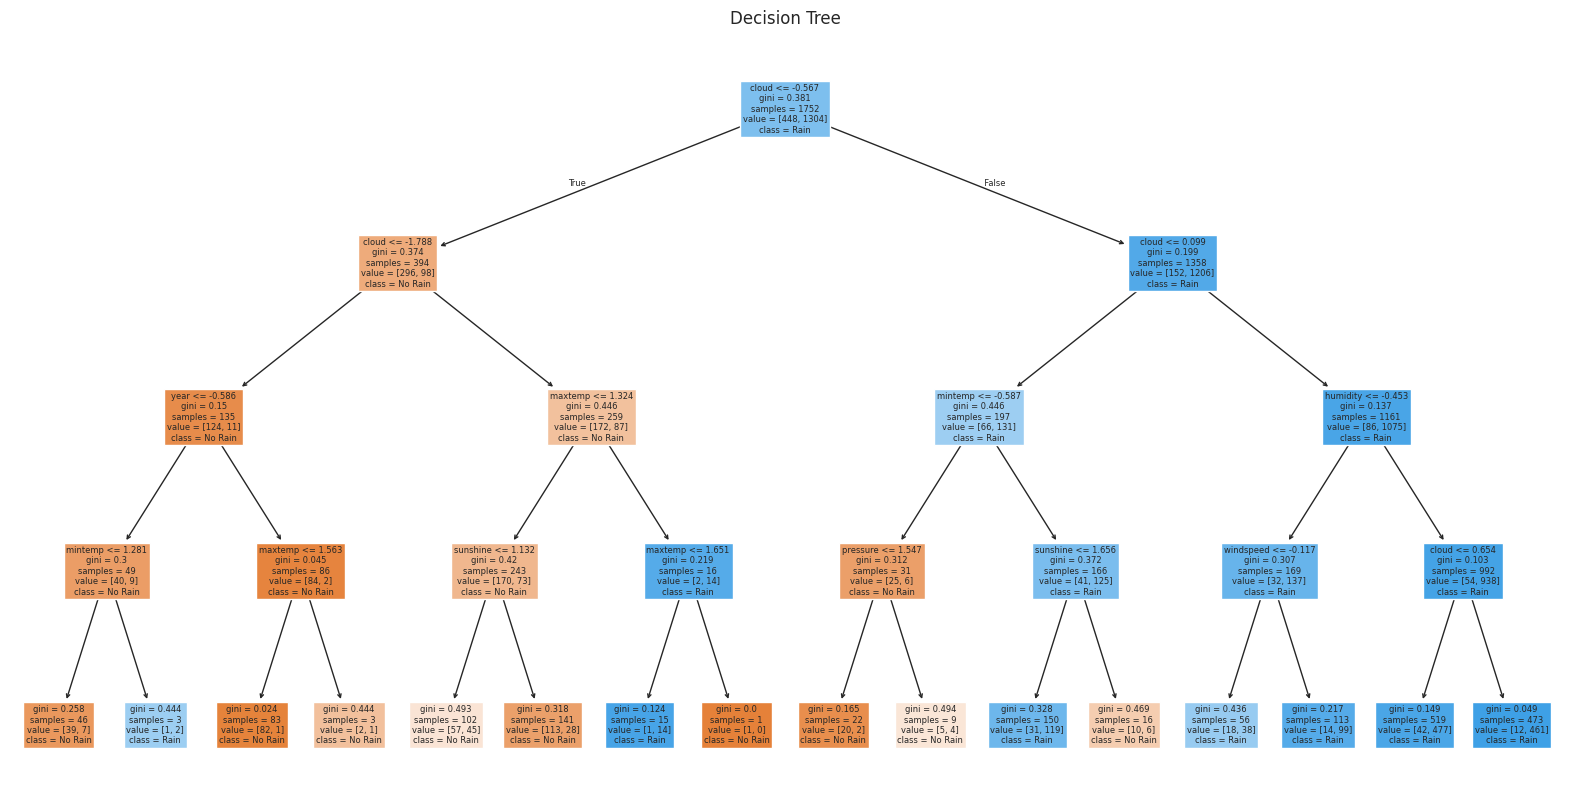

In [22]:
# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier, plot_tree
tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

# Evaluate model
y_pred = tree_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X.columns, class_names=['No Rain', 'Rain'], filled=True)
plt.title("Decision Tree")
plt.show()

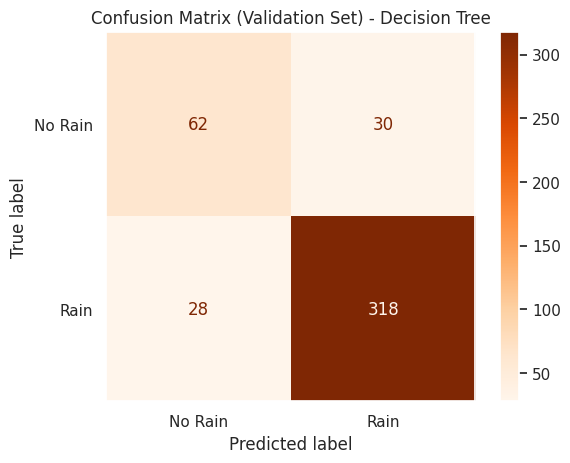

In [23]:
# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain", "Rain"])
disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix (Validation Set) - Decision Tree")
plt.grid(False)
plt.show()

In [24]:
# Get predicted probabilities for the positive class
test_probs = tree_model.predict_proba(X_test_scaled)[:, 1]  # probability of class 1

# If there's an 'id' column in test_df
submission = pd.DataFrame({
    "id": test_df["id"],
    "rainfall": test_probs
})

# Save to CSV
submission.to_csv(PATH + "submission_tree.csv", index=False)

### Decision Forest Model

Validation Accuracy: 0.8744292237442922

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.62      0.67        92
           1       0.90      0.94      0.92       346

    accuracy                           0.87       438
   macro avg       0.82      0.78      0.80       438
weighted avg       0.87      0.87      0.87       438



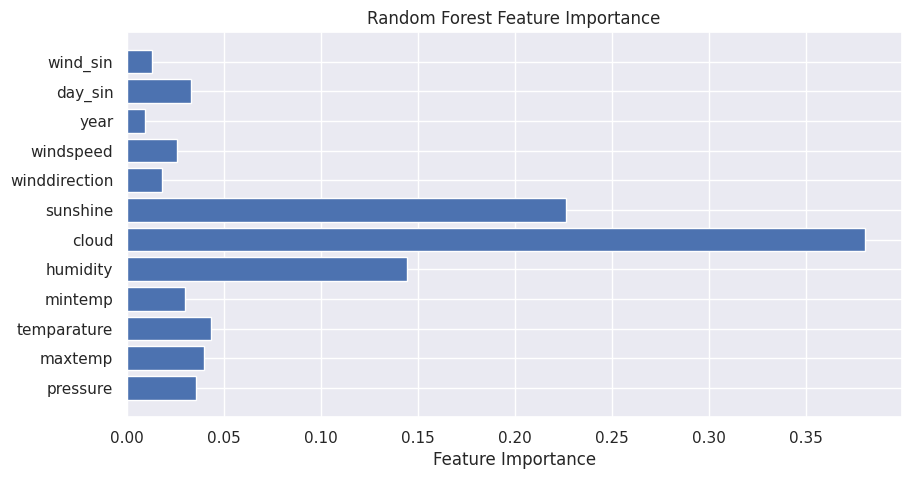

In [25]:
# Decision Forest
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42)
forest_model.fit(X_train, y_train)

# Evaluate on validation data
y_pred = forest_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Feature Importance Visualization
importances = forest_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 5))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

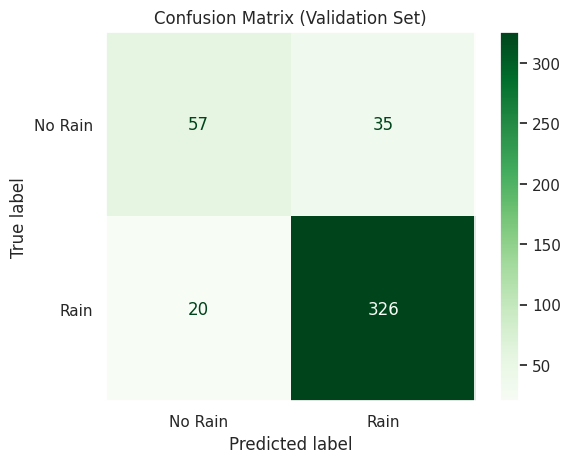

In [26]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain", "Rain"])
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix (Validation Set)")
plt.grid(False)
plt.show()

In [27]:
# Get predicted probabilities for the positive class
test_probs = forest_model.predict_proba(X_test_scaled)[:, 1]  # probability of class 1

# If there's an 'id' column in test_df
submission = pd.DataFrame({
    "id": test_df["id"],
    "rainfall": test_probs
})

# Save to CSV
submission.to_csv(PATH + "submission_forest.csv", index=False)

### XGB Classifier

Training Accuracy: 0.9886
Validation Accuracy: 0.8721


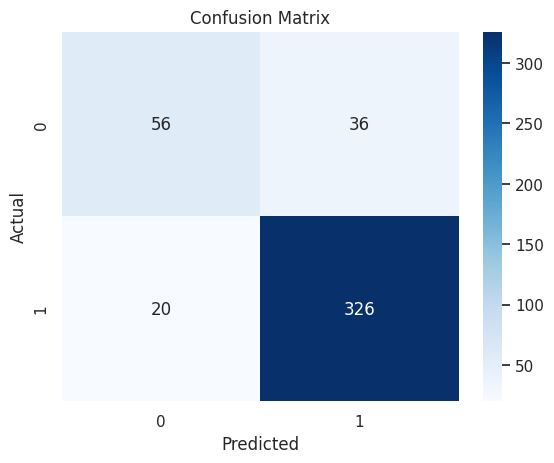

In [28]:
model_xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3,  # if rainfall is imbalanced
    random_state=42
)

model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc:.4f}")


y_pred = model_xgb.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")
#print(classification_report(y_val, y_pred))


cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Get predicted probabilities for the positive class
test_probs = model_xgb.predict_proba(X_test_scaled)[:, 1]  # probability of class 1

# If there's an 'id' column in test_df
submission = pd.DataFrame({
    "id": test_df["id"],
    "rainfall": test_probs
})

# Save to CSV
submission.to_csv(PATH + "submission_XGboost.csv", index=False)

[0]	validation_0-auc:0.85844
[100]	validation_0-auc:0.86887
[101]	validation_0-auc:0.86884
Validation ROC AUC: 0.8783142749434532
Validation Accuracy: 0.7900


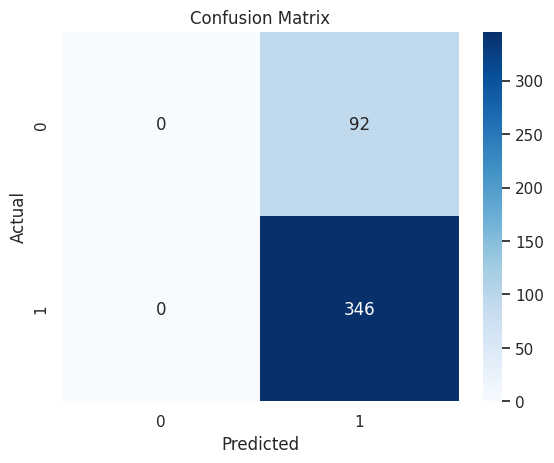

In [29]:
# Another XGB model
model_xgb2 = XGBClassifier(
    max_depth=6,
    colsample_bytree=0.9,
    subsample=0.9,
    n_estimators=10_000,
    learning_rate=0.1,
    eval_metric="auc",
    early_stopping_rounds=100,
    alpha=1,
    random_state=42
)

# Train the model
model_xgb2.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

# Predict probabilities
oof_xgb = model_xgb2.predict_proba(X_val)[:, 1]

# Optionally evaluate
print("Validation ROC AUC:", roc_auc_score(y_val, oof_xgb))

y_pred = model_xgb2.predict(X_val)
acc2 = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc2:.4f}")
#print(classification_report(y_val, y_pred))


cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Get predicted probabilities for the positive class
test_probs = model_xgb2.predict_proba(X_test_scaled)[:, 1]  # probability of class 1


submission = pd.DataFrame({
    "id": test_df["id"],
    "rainfall": test_probs
})

# Save to CSV
submission.to_csv(PATH + "submission_XGboost2.csv", index=False)

### Neural Network

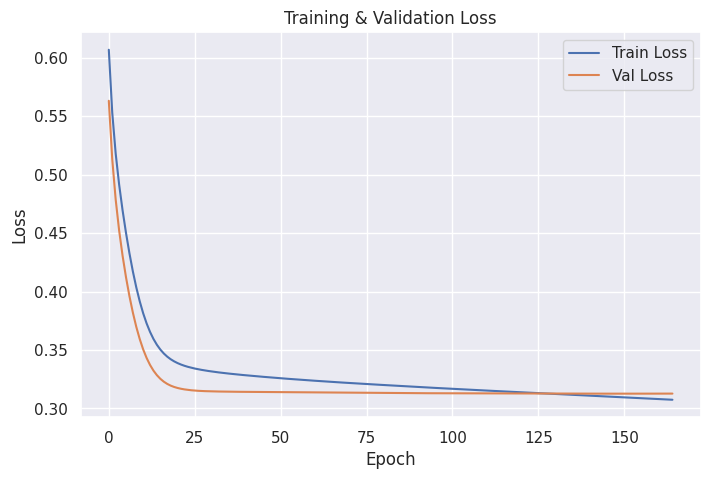

Training Accuracy: 0.8761
Validation Accuracy: 0.8721


In [30]:
# NN
# Clear session
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# Build final model
nn_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(112, activation='relu'),  # Layer 1
    layers.Dense(224, activation='relu'),  # Layer 2
    layers.Dense(160, activation='relu'),  # Layer 3
    # No dropout
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile with SGD and lr = 0.02
nn_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=0
)

# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Evaluate on training and validation sets
train_loss, train_acc = nn_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = nn_model.evaluate(X_val, y_val, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


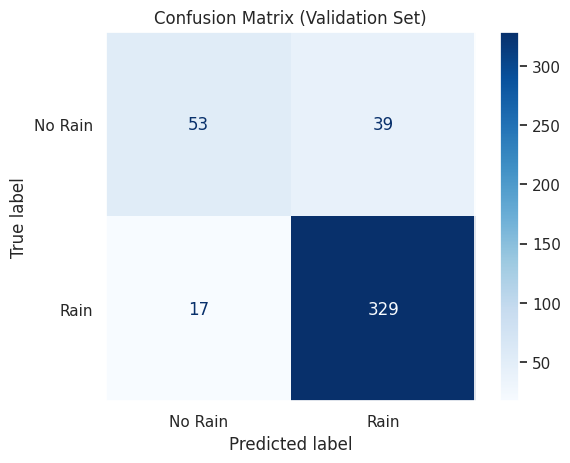


Classification Report:
              precision    recall  f1-score   support

     No Rain       0.76      0.58      0.65        92
        Rain       0.89      0.95      0.92       346

    accuracy                           0.87       438
   macro avg       0.83      0.76      0.79       438
weighted avg       0.87      0.87      0.87       438

Validation ROC AUC: 0.8883827594873083


In [31]:
# Get predicted probabilities on validation set
y_val_probs = nn_model.predict(X_val)

# Convert probabilities to class labels (0 or 1)
y_val_preds = (y_val_probs > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain", "Rain"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.grid(False)
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_preds, target_names=["No Rain", "Rain"]))
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_probs))

In [32]:
# Get predicted probabilities for the positive class
test_probs = nn_model.predict(X_test_scaled)


submission = pd.DataFrame({
    "id": test_df["id"],
    "rainfall": test_probs.flatten()
})

# Save to CSV
submission.to_csv(PATH + "submission_nn.csv", index=False)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


### 1D CNN

In [33]:
# CNN
window_size = 8

# Function to create sequences
def create_sequences(X, y, window_size):
    X_seq = []
    y_seq = []
    for i in range(len(X) - window_size + 1):
        X_seq.append(X[i : i + window_size])  # 8-day window
        y_seq.append(y[i + window_size - 1])  # label of last day in window
    return np.array(X_seq), np.array(y_seq)

# Generate sequences
X_seq, y_seq = create_sequences(X.values, y.values, window_size=window_size)

# Reshape X_seq for scaling: (samples * window_size, num_features)
num_samples, num_days, num_features = X_seq.shape
X_seq_2d = X_seq.reshape(-1, num_features)

# Scale the 2D version
scaler = StandardScaler()
X_seq_scaled_2d = scaler.fit_transform(X_seq_2d)

# Reshape back to (samples, window_size, num_features)
X_seq_scaled = X_seq_scaled_2d.reshape(num_samples, num_days, num_features)

# Train-validation split
# Time-based train-validation split (80% train, 20% validation)
split_index = int(len(X_seq_scaled) * 0.8)
X_train_seq = X_seq_scaled[:split_index]
X_val_seq = X_seq_scaled[split_index:]
y_train_seq = y_seq[:split_index]
y_val_seq = y_seq[split_index:]

In [34]:
print(X_train_seq[0])
print("X_seq shape:", X_train_seq.shape)
print("X_seq shape:", X_val_seq.shape)

[[ 0.67397196 -0.91887634 -0.64644794 -0.45274503  0.63892102  0.68217836
  -0.73087155 -0.56263476 -0.46379094 -1.46653978 -0.02011487  0.82078886]
 [ 1.0453886  -1.80436923 -1.35564335 -1.26390571  1.66670316  0.84860842
  -1.03418993 -0.68755941  0.01144836 -1.46653978  0.00415576  0.66770424]
 [ 1.8589679  -1.23765378 -1.5089829  -1.50131859 -0.90275218 -1.59236577
   1.25448511 -0.43771011 -0.37278767 -1.46653978  0.0284192   0.93358352]
 [-0.0334883  -1.46788193 -1.18313636 -1.04627724  1.66670316  1.07051516
  -1.03418993 -0.56263476  1.39672037 -1.46653978  0.05266826  0.82078886]
 [ 1.45217825 -0.90116648 -1.06813169 -1.38261215 -3.85762582 -1.70331915
  -0.0415116  -0.81248406  0.30468112 -1.46653978  0.07689575  0.47898105]
 [ 1.6113568  -1.02513549 -1.02979681 -1.12541486 -0.38886111  0.29384156
  -1.03418993 -1.06233336 -0.61546306 -1.46653978  0.1010945   0.01846462]
 [ 1.62904331 -1.21994392 -1.06813169 -1.36282774 -3.34373475 -1.64784246
   1.06146433 -1.06233336  0.668

In [35]:
print(y_train_seq.shape)
y_val_seq.shape
print("X_train_seq shape:", X_seq.shape)
print("y_train shape:", y_seq.shape)

(1746,)
X_train_seq shape: (2183, 8, 12)
y_train shape: (2183,)


In [36]:
# Clear any existing model
tf.keras.backend.clear_session()

# Build Conv1D model
model_1d_cnn = tf.keras.Sequential()

# Add 1D convolutional layer
model_1d_cnn.add(tf.keras.layers.Conv1D(
    filters=128,
    kernel_size=4,
    strides=1,
    padding='same',
    activation='relu',
    input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # (timesteps, features)
    name='conv1d_1'
))

# Add 1D max pooling
model_1d_cnn.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# Dropout for regularization
model_1d_cnn.add(tf.keras.layers.Dropout(0.5))

# Flatten and output
model_1d_cnn.add(tf.keras.layers.Flatten())
model_1d_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile model
model_1d_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_1d_cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 8, 128)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,785 (26.50 KB)

 Trainable params: 6,785 (26.50 KB)

 Non-trainable params: 0 (0.00 B)

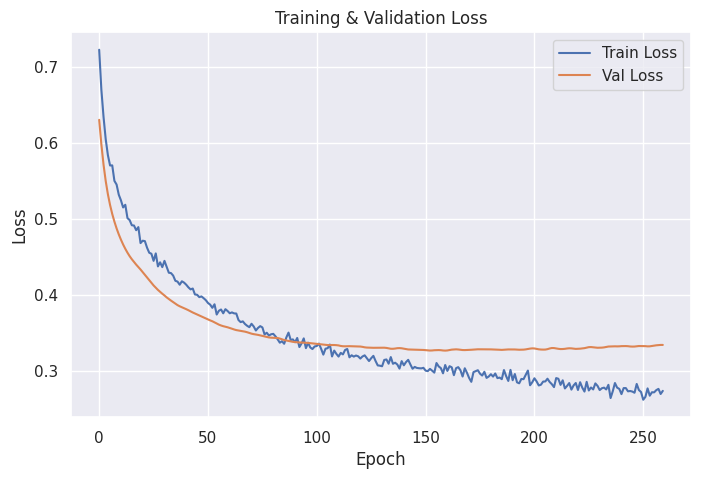

In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True,
    verbose=0
)

history = model_1d_cnn.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=300,
    batch_size=1024,
    callbacks=[early_stopping],
    verbose = 0
)

# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8846 - loss: 0.2878
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8843 - loss: 0.3300 
Training Accuracy: 0.8877
Validation Accuracy: 0.8833
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


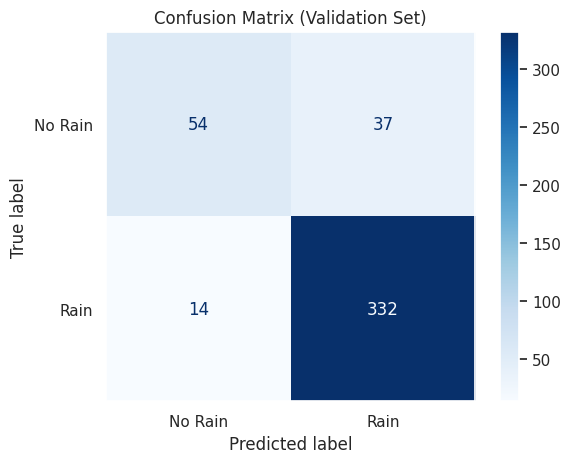

In [38]:
# Evaluate
train_loss, train_acc = model_1d_cnn.evaluate(X_train_seq, y_train_seq)
val_loss, val_acc = model_1d_cnn.evaluate(X_val_seq, y_val_seq)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Predict probabilities
y_val_probs = model_1d_cnn.predict(X_val_seq)

# Convert probabilities to binary predictions
y_val_preds = (y_val_probs > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_val_seq, y_val_preds)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain", "Rain"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.grid(False)
plt.show()

In [39]:
# Load the test data
test_df = pd.read_csv(PATH + 'test_extra7.csv')


test_df['date'] = pd.to_datetime(test_df['day'], format='%j', errors='coerce')

# Simulate year assignment just like train_df (e.g., assume up to 6 years of data)
test_df['year'] = (test_df.index // 365)

# Extract month from synthetic date
test_df['month'] = test_df['date'].dt.month

# Create cyclical features
test_df['day_sin'] = np.sin(2 * np.pi * (test_df['day'] - 1) / 365)
test_df['wind_sin'] = np.sin(2 * np.pi * test_df['winddirection'] / 360)


# Step 2: Select the same feature columns
X_test = test_df[columns_to_keep]

# Step 3: Scale using the same scaler
X_test_scaled = scaler.transform(X_test)

# Create sequences
X_test_seq, _ = create_sequences(X_test.values, np.zeros(len(X_test)), window_size=window_size)

# Reshape for scaling
num_samples_test, num_days_test, num_features_test = X_test_seq.shape
X_test_2d = X_test_seq.reshape(-1, num_features_test)

# Apply the SAME scaler from training
X_test_scaled_2d = scaler.transform(X_test_2d)

# Reshape back to 3D for CNN
X_test_cnn = X_test_scaled_2d.reshape(num_samples_test, num_days_test, num_features_test)

# Make predictions
y_test_pred = model_1d_cnn.predict(X_test_cnn).flatten()

# Align with correct IDs (assume ID starts from index 7 after 8-day sequences)
submission_ids = test_df['id'].iloc[window_size - 1:].reset_index(drop=True)

# Build submission DataFrame
submission = pd.DataFrame({
    'id': submission_ids,
    'rainfall': y_test_pred
})

# Save to CSV
submission.to_csv(PATH + 'submission_1d_cnn.csv', index=False)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


### 2D CNN

In [40]:
# One Layer CNN
tf.keras.backend.clear_session()

# Reshape input for Conv2D: (samples, height, width, channels)
X_train_2d = X_train_seq.reshape(-1, window_size, X.shape[1], 1)
X_val_2d = X_val_seq.reshape(-1, window_size, X.shape[1], 1)

# Build Conv2D model
tf.keras.backend.clear_session()
model_2d_cnn = tf.keras.Sequential()

# Add convolutional layer
model_2d_cnn.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_1',
    input_shape=(window_size, X.shape[1], 1)  # (height, width, channels)
))

# Add max pooling layer
model_2d_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add dropout layer
model_2d_cnn.add(tf.keras.layers.Dropout(rate=0.5))

# Add flattening layer
model_2d_cnn.add(tf.keras.layers.Flatten())

# Add classification layer
model_2d_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile model
model_2d_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Print summary
model_2d_cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 8, 12, 128)     │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         3,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,249 (20.50 KB)

 Trainable params: 5,249 (20.50 KB)

 Non-trainable params: 0 (0.00 B)

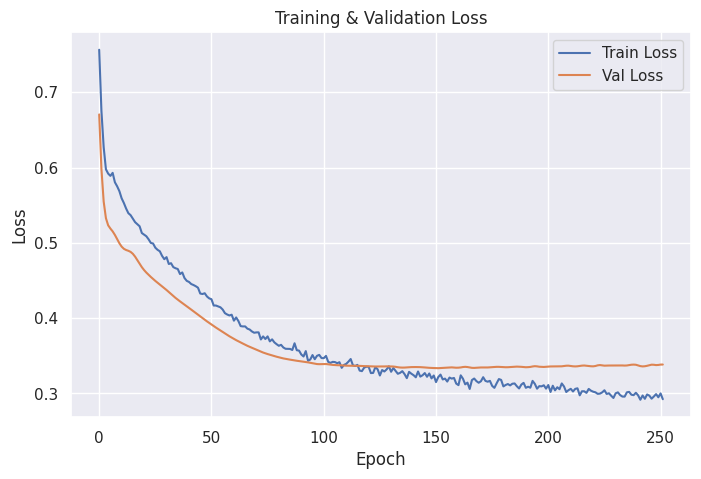

In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True,
)

history = model_2d_cnn.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=300,
    batch_size=1024,
    callbacks=[early_stopping],
    verbose = 0
)

# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()



In [42]:
# Evaluate
train_loss, train_acc = model_2d_cnn.evaluate(X_train_seq, y_train_seq)
val_loss, val_acc = model_2d_cnn.evaluate(X_val_seq, y_val_seq)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8648 - loss: 0.3187
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8723 - loss: 0.3393 
Training Accuracy: 0.8717
Validation Accuracy: 0.8719


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


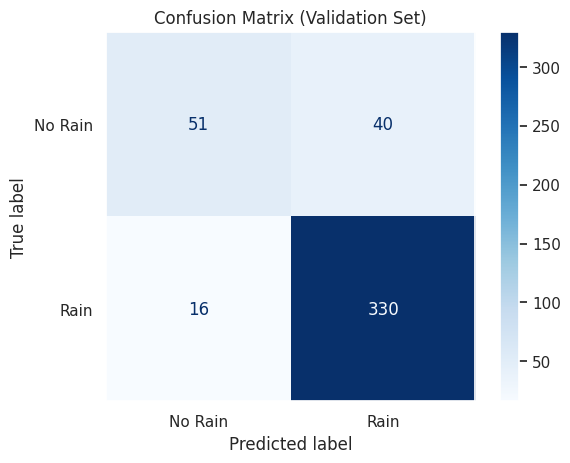

In [43]:
# Predict probabilities
y_val_probs = model_2d_cnn.predict(X_val_seq)

# Convert probabilities to binary predictions
y_val_preds = (y_val_probs > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_val_seq, y_val_preds)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain", "Rain"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.grid(False)
plt.show()

In [44]:
# Apply to test set
y_test_pred = model_2d_cnn.predict(X_test_cnn).flatten()

submission = pd.DataFrame({
    'id': submission_ids,
    'rainfall': y_test_pred
})

# Save to CSV
submission.to_csv(PATH + 'submission_2d_cnn.csv', index=False)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [45]:
# Two-Layer CNN model
tf.keras.backend.clear_session()
model_2d_cnn2 = tf.keras.Sequential()

# Add convolutional layer
model_2d_cnn2.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(4, 8),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_1',
    input_shape=(window_size, X.shape[1], 1)  # (height, width, channels)
))

# Add max pooling layer
model_2d_cnn2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add dropout layer
model_2d_cnn2.add(tf.keras.layers.Dropout(rate=0.6))

model_2d_cnn2.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(2, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_2')  # (height, width, channels)
)

# Add max pooling layer
model_2d_cnn2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add dropout layer
model_2d_cnn2.add(tf.keras.layers.Dropout(rate=0.6))

# Add flattening layer
model_2d_cnn2.add(tf.keras.layers.Flatten())

# Add classification layer
model_2d_cnn2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile model
model_2d_cnn2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Print summary
model_2d_cnn2.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 8, 12, 128)     │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 4, 6, 32)       │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,217 (145.38 KB)

 Trainable params: 37,217 (145.38 KB)

 Non-trainable params: 0 (0.00 B)

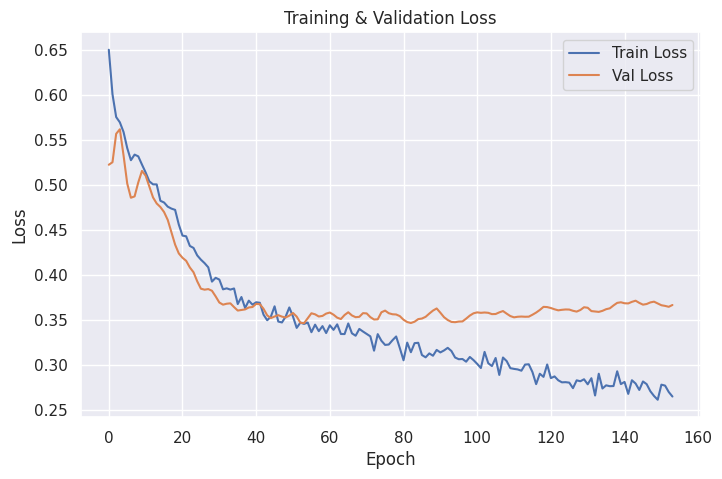

In [46]:
# Fit the model
history = model_2d_cnn2.fit(
    X_train_2d, y_train_seq,
    validation_data=(X_val_2d, y_val_seq),
    epochs=300,
    batch_size=1024,
    callbacks=[early_stopping],
    verbose = 0
)
# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [47]:
# Evaluate
train_loss, train_acc = model_2d_cnn2.evaluate(X_train_2d, y_train_seq)
val_loss, val_acc = model_2d_cnn2.evaluate(X_val_2d, y_val_seq)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8780 - loss: 0.3127
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8718 - loss: 0.3392 
Training Accuracy: 0.8820
Validation Accuracy: 0.8673


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


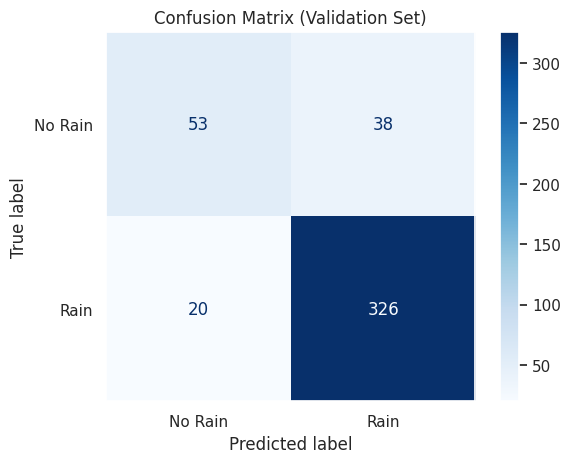

In [48]:
# Predict probabilities
y_val_probs = model_2d_cnn2.predict(X_val_2d)

# Convert probabilities to binary predictions
y_val_preds = (y_val_probs > 0.5).astype("int32")

# Generate confusion matrix
cm2 = confusion_matrix(y_val_seq, y_val_preds)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["No Rain", "Rain"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.grid(False)
plt.show()


In [49]:
# Apply to test set

X_test_2d = X_test_cnn.reshape(-1, window_size, X.shape[1], 1)
y_test_pred = model_2d_cnn2.predict(X_test_2d).flatten()

submission = pd.DataFrame({
    'id': submission_ids,
    'rainfall': y_test_pred
})

# Save to CSV
submission.to_csv(PATH + 'submission_2d_cnn2.csv', index=False)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 12, 32)      │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 12, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 4, 6, 32)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 6, 16)       │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 6, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 2, 3, 16)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 3, 16)       │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 3, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 1, 1, 16)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,505 (29.32 KB)

 Trainable params: 7,377 (28.82 KB)

 Non-trainable params: 128 (512.00 B)

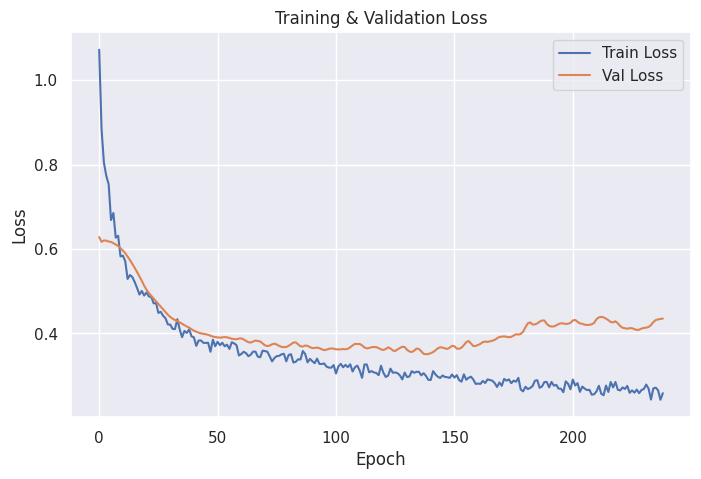

In [50]:
model_tf3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (4, 8), padding='same', activation='relu', input_shape=(window_size, X.shape[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.SpatialDropout2D(0.5),

    tf.keras.layers.Conv2D(16, (2, 4), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.SpatialDropout2D(0.5),

    tf.keras.layers.Conv2D(16, (2, 4), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.SpatialDropout2D(0.5),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_tf3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Print summary
model_tf3.summary()
# Fit the model
history = model_tf3.fit(
    X_train_2d, y_train_seq,
    validation_data=(X_val_2d, y_val_seq),
    epochs=300,
    batch_size=1024,
    callbacks=[early_stopping],
    verbose = 0
)
# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [51]:
# Evaluate
train_loss, train_acc = model_tf3.evaluate(X_train_2d, y_train_seq)
val_loss, val_acc = model_tf3.evaluate(X_val_2d, y_val_seq)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8859 - loss: 0.2597
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.3491 
Training Accuracy: 0.8952
Validation Accuracy: 0.8696


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


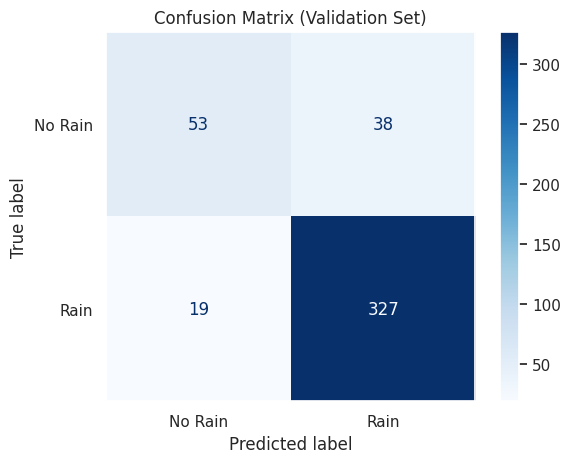

In [52]:
# Predict probabilities
y_val_probs = model_tf3.predict(X_val_2d)

# Convert probabilities to binary predictions
y_val_preds = (y_val_probs > 0.5).astype("int32")

# Generate confusion matrix
cm2 = confusion_matrix(y_val_seq, y_val_preds)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["No Rain", "Rain"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.grid(False)
plt.show()


In [53]:
# Apply to test set

y_test_pred = model_tf3.predict(X_test_2d).flatten()

submission = pd.DataFrame({
    'id': submission_ids,
    'rainfall': y_test_pred
})

# Save to CSV
submission.to_csv(PATH + 'submission_2d_cnn3.csv', index=False)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


### LSTM

In [54]:
def build_model(input_shape):
    model = Sequential([
       # Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape),
       # BatchNormalization(),
       # Dropout(0.5),
        LSTM(64, return_sequences=True, input_shape=input_shape),
       # LSTM(64, return_sequences=True),
       # BatchNormalization(),
        Dropout(0.5),

        LSTM(64, return_sequences=False),
       # BatchNormalization(),
        Dropout(0.5),

       # LSTM(32),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

(1, 12)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,557 (717.02 KB)

 Trainable params: 61,185 (239.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 122,372 (478.02 KB)

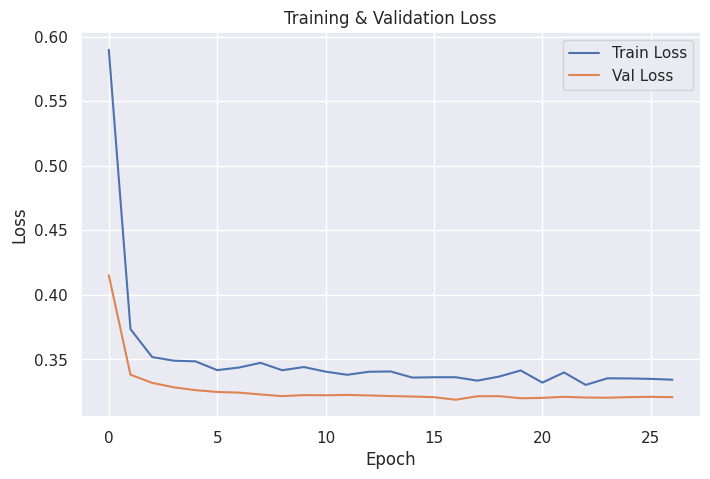

In [55]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose = 0
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

import numpy as np

# Reshape X_train and X_val to be 3D
# We need to add a 'timesteps' dimension. Assuming timesteps = 1:
X_train_3D = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_3D = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

# Check the shape
input_shape = X_train_3D.shape[1:]  # (window_size, num_features)
print(input_shape)

model_lstm = build_model(input_shape)

history = model_lstm.fit(
    X_train_3D, y_train,
    validation_data=(X_val_3D, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose = 0
    # class_weight={0: 1., 1: 3.}  # Only if rainfall is imbalanced
)

# Print summary
model_lstm.summary()
# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8631 - loss: 0.3395
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8795 - loss: 0.3145 
Training Accuracy: 0.8710
Validation Accuracy: 0.8721
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


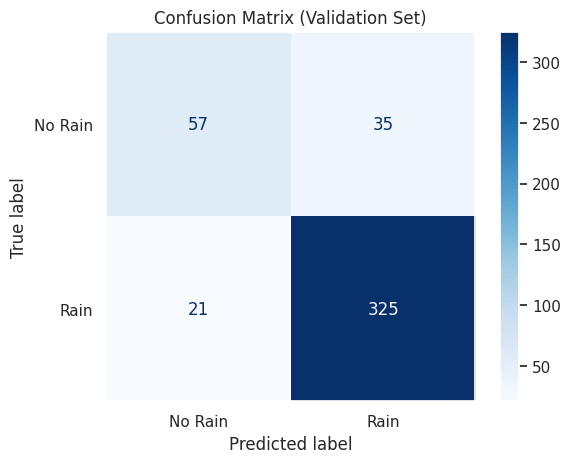

In [56]:
# Evaluate
train_loss, train_acc = model_lstm.evaluate(X_train_3D, y_train)
val_loss, val_acc = model_lstm.evaluate(X_val_3D, y_val)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
# Predict probabilities
y_val_probs = model_lstm.predict(X_val_3D)

# Convert probabilities to binary predictions
y_val_preds = (y_val_probs > 0.5).astype("int32")

# Generate confusion matrix
cm2 = confusion_matrix(y_val, y_val_preds)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["No Rain", "Rain"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.grid(False)
plt.show()


In [57]:
# Apply to test set

X_test_3D = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
y_test_pred = model_lstm.predict(X_test_3D).flatten()

y_test_pred = y_test_pred[7:]


submission = pd.DataFrame({
    'id': submission_ids,
    'rainfall': y_test_pred
})

# Save to CSV
submission.to_csv(PATH + 'submission_lstm.csv', index=False)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


### GRU

(1, 12)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,253 (286.15 KB)

 Trainable params: 24,417 (95.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 48,836 (190.77 KB)

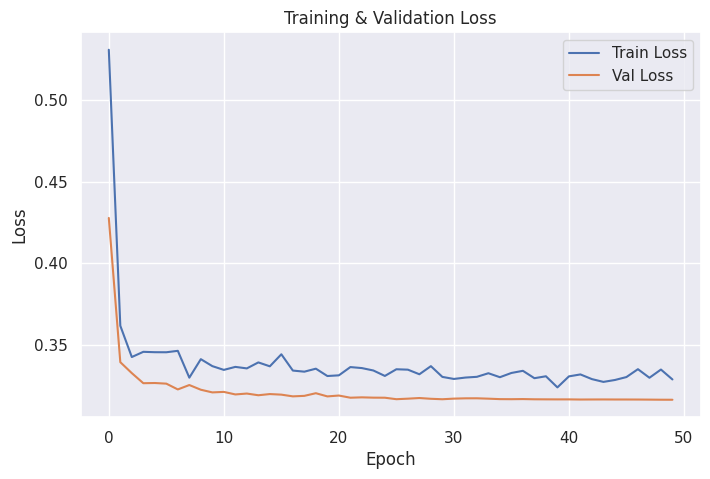

In [58]:
def build_GRU_model(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        GRU(32),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

input_shape = X_train_3D.shape[1:]  # (window_size, num_features)
print(input_shape)

model_gru = build_GRU_model(input_shape)

history = model_gru.fit(
    X_train_3D, y_train,
    validation_data=(X_val_3D, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose = 0
    #class_weight={0: 1., 1: 3.}  # Only if rainfall is imbalanced
)

# Print summary
model_gru.summary()
# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8588 - loss: 0.3372
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8892 - loss: 0.3155 
Training Accuracy: 0.8682
Validation Accuracy: 0.8744
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


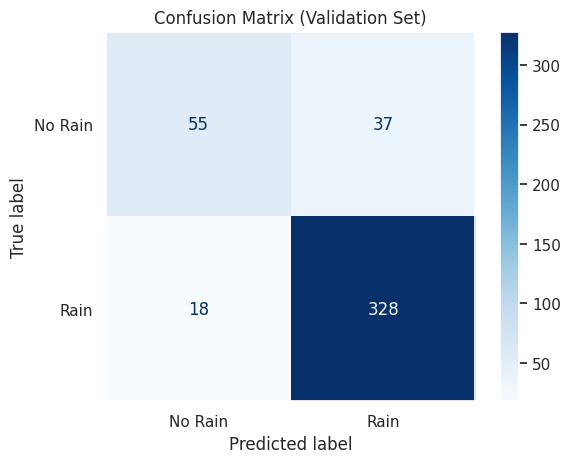

In [59]:
# Evaluate
train_loss, train_acc = model_gru.evaluate(X_train_3D, y_train)
val_loss, val_acc = model_gru.evaluate(X_val_3D, y_val)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
# Predict probabilities
y_val_probs = model_gru.predict(X_val_3D)

# Convert probabilities to binary predictions
y_val_preds = (y_val_probs > 0.5).astype("int32")

# Generate confusion matrix
cm2 = confusion_matrix(y_val, y_val_preds)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["No Rain", "Rain"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.grid(False)
plt.show()


In [60]:
# Apply to test set
y_test_pred = model_gru.predict(X_test_3D).flatten()

y_test_pred = model_lstm.predict(X_test_3D).flatten()

y_test_pred = y_test_pred[7:]
submission = pd.DataFrame({
    'id': submission_ids,
    'rainfall': y_test_pred
})

# Save to CSV
submission.to_csv(PATH + 'submission_gru.csv', index=False)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


### Ensamble

In [61]:
# List of our submission files
submission_files = [
    "submission_lr.csv",
    "submission_XGboost.csv",
    "submission_XGboost2.csv",
    "submission_nn.csv",
    "submission_1d_cnn.csv",
    "submission_2d_cnn.csv",
    "submission_2d_cnn2.csv",
    "submission_2d_cnn3.csv",
    "submission_lstm.csv",
    "submission_gru.csv",
    "submission_knn.csv",
]

dfs = [pd.read_csv(PATH + f) for f in submission_files]

# Stack all probability columns and compute the mean
probs = pd.concat([df["rainfall"] for df in dfs], axis=1)
avg_probs = probs.mean(axis=1)

# Create final submission
ensemble_submission = pd.DataFrame({
    "id": dfs[0]["id"],
    "probability": avg_probs
})

# Save to CSV
ensemble_submission.to_csv(PATH + "submission_ensemble.csv", index=False)